# The Packages

In [1]:
import numpy as np
import pandas as pd
import os
import gc
import datetime
import warnings

In [2]:

import statsmodels.api as sm
from datetime import date

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
import tensorflow as tf
import math 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM
from tensorflow.keras import losses
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.utils import plot_model

In [5]:
tf.__version__

'2.10.1'

In [6]:
# DATA VISUALIZATION
# ------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.set_style("darkgrid")
sns.color_palette("mako", as_cmap=True)
import plotly.express as px


In [7]:
# CONFIGURATIONS
# ------------------------------------------------------
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

# Utility Functions

In [8]:
def plotSeries(time, series, lab,form='-'):
    plt.plot(time, series, form, label=lab)
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.grid(True)

# The Data

In [9]:
wfc = pd.read_csv('Dataset/WFC Daily1.csv')

In [10]:
wfc.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,20.16,20.19,19.00,19.56,10.44,9037000
1,2000-01-04,18.62,18.84,18.00,18.59,9.92,15237200
2,2000-01-05,18.50,18.88,18.03,18.41,9.82,8228200
3,2000-01-06,18.53,19.50,18.47,19.22,10.25,8326800
4,2000-01-07,19.62,19.84,19.28,19.56,10.44,7711200


In [11]:
wfc.Date.dtype

dtype('O')

In [12]:
wfc['Date'] = pd.to_datetime(wfc['Date'])
#wfc.set_index(['Date'],inplace=True)

In [13]:
wfc.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,20.16,20.19,19.00,19.56,10.44,9037000
1,2000-01-04,18.62,18.84,18.00,18.59,9.92,15237200
2,2000-01-05,18.50,18.88,18.03,18.41,9.82,8228200
3,2000-01-06,18.53,19.50,18.47,19.22,10.25,8326800
4,2000-01-07,19.62,19.84,19.28,19.56,10.44,7711200


In [14]:
wfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5754 entries, 0 to 5753
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5754 non-null   datetime64[ns]
 1   Open       5754 non-null   float64       
 2   High       5754 non-null   float64       
 3   Low        5754 non-null   float64       
 4   Close      5754 non-null   float64       
 5   Adj Close  5754 non-null   float64       
 6   Volume     5754 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 314.8 KB


In [15]:
wfc.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5754.00,5754.00,5754.00,5754.00,5754.00,5754.00
mean,36.38,36.78,35.98,36.38,28.01,24313450.19
std,11.74,11.77,11.73,11.75,12.85,26705062.78
min,8.65,8.94,7.80,8.12,5.76,1774000.00
25%,26.71,27.20,26.25,26.74,18.01,10091200.00
50%,32.65,33.13,32.25,32.64,23.18,17086600.00
75%,47.75,48.19,47.33,47.79,41.58,29145250.00
max,65.89,66.31,65.66,65.93,57.96,478736600.00


In [16]:
correlation = wfc.corr ()  
correlation. style.background_gradient ()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999324,0.999274,0.998754,0.965403,-0.184389
High,0.999324,1.000000,0.998796,0.999323,0.967945,-0.169457
Low,0.999274,0.998796,1.000000,0.999303,0.963519,-0.199335
Close,0.998754,0.999323,0.999303,1.000000,0.966149,-0.183272
Adj Close,0.965403,0.967945,0.963519,0.966149,1.000000,-0.080189
Volume,-0.184389,-0.169457,-0.199335,-0.183272,-0.080189,1.000000


# The Split

In [17]:
min_date = wfc.Date.min()
max_date = wfc.Date.max()
print("Min:", min_date, "Max:", max_date)

Min: 2000-01-03 00:00:00 Max: 2022-11-11 00:00:00


In [18]:
train_percent = .75
valid_percent = .12

time_between = max_date - min_date

train_cutoff = min_date + train_percent*time_between
valid_cutoff = min_date + (train_percent + valid_percent)*time_between

print("Training Cutoff Date: {:s}".format(str(train_cutoff)))
print("Validation Cutoff Date: {:s}".format(str(valid_cutoff)))

Training Cutoff Date: 2017-02-23 00:00:00
Validation Cutoff Date: 2019-11-21 18:14:24


In [19]:
train_df = wfc[wfc.Date <= train_cutoff]
valid_df = wfc[(wfc.Date > train_cutoff) & (wfc.Date <= valid_cutoff)]
test_df = wfc[wfc.Date > valid_cutoff]


In [20]:
print("Dataset shape: {:s}".format(str(wfc.shape)))
print("Train dataset shape: {:s}".format(str(train_df.shape)))
print("Vaid dataset shape: {:s}".format(str(valid_df.shape)))
print("Test dataset shape: {:s}".format(str(test_df.shape)))

Dataset shape: (5754, 7)
Train dataset shape: (4313, 7)
Vaid dataset shape: (692, 7)
Test dataset shape: (749, 7)


# Stock Price Graph

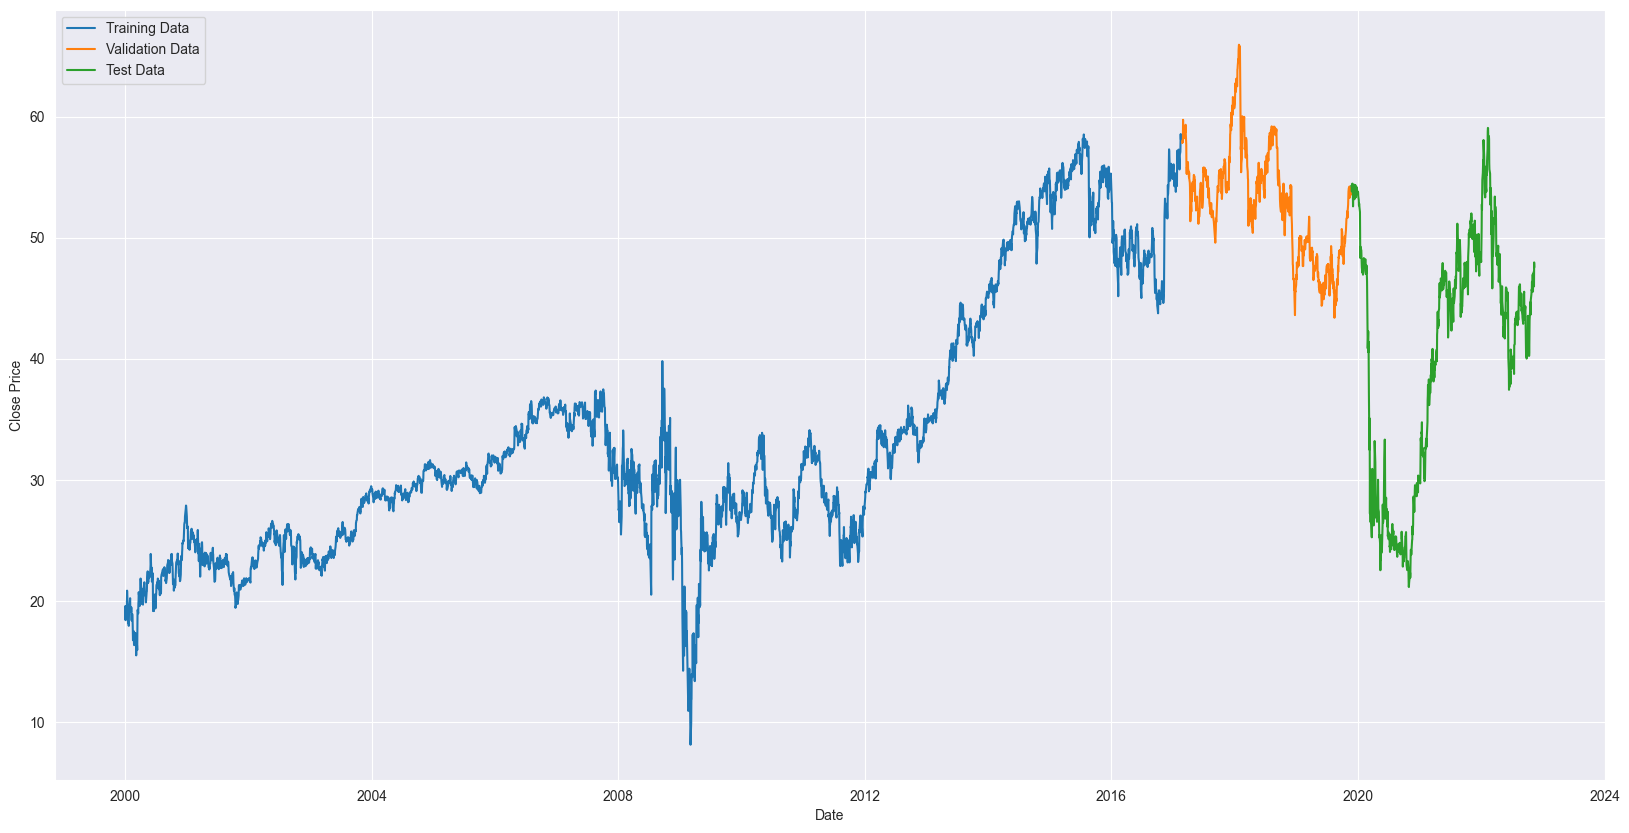

In [21]:
plotSeries(train_df.Date, train_df.Close, "Training Data")
plotSeries(valid_df.Date, valid_df.Close, "Validation Data")
plotSeries(test_df.Date, test_df.Close, "Test Data")
plt.legend(loc='upper left')

In [22]:
train_df.set_index(['Date'],inplace=True)
test_df.set_index(['Date'],inplace=True)
valid_df.set_index(['Date'],inplace=True)

In [23]:
trainNorm = train_df.Close.values.reshape(-1, 1)
testNorm = test_df.Close.values.reshape(-1, 1)
validNorm = valid_df.Close.values.reshape(-1, 1)

In [24]:
trainNorm.shape

(4313, 1)

## Windowed Dataset

In [25]:
mse_arr=[]
Z = []

window = 4

In [26]:
X_train= []
Y_train=[]
X_valid= []
Y_valid=[]
X_test= []
Y_test=[]

for i in range(len(trainNorm) - (window)):
    X_train.append(trainNorm[i:i+window])
    Y_train.append(trainNorm[i+window])
    
for i in range(len(validNorm) - (window)):
    X_valid.append(validNorm[i:i+window])
    Y_valid.append(validNorm[i+window])
    
for i in range(len(testNorm) - (window)):
    X_test.append(testNorm[i:i+window])
    Y_test.append(testNorm[i+window])
    

X_train=np.asanyarray(X_train)
Y_train=np.asanyarray(Y_train)
X_valid=np.asanyarray(X_valid)
Y_valid=np.asanyarray(Y_valid)
X_test=np.asanyarray(X_test)
Y_test=np.asanyarray(Y_test)

Xtrain = X_train[:,:,:]  
Ytrain = Y_train[:]  
Xvalid = X_valid[:,:,:]  
Yvalid= Y_valid[:]  
Xtest = X_test[:,:,:]  
Ytest= Y_test[:]  

# Model Building

In [27]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential()

In [28]:
model.add(keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)))
model.add(keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)))
model.add(keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))
model.add(keras.layers.Dense(1))

## Final Model Build

In [29]:
tf.keras.backend.clear_session()

In [30]:
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=Adam(1e-3),
              metrics=['mae'])

In [31]:
log_dir = "logs\\" + datetime.datetime.now().strftime("%d-%m-%Y_%H%M%S")

tensorboard_callback = [
#                         tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
#                         ModelCheckpoint(model_path, verbose=1, save_best_only=True),
#                         ReduceLROnPlateau(monitor= "val_mae", factor=0.1, patience=5, min_lr=1e-7, verbose=1),
                        ReduceLROnPlateau(monitor='val_mae', factor=0.3,patience=5, min_lr=1e-6, verbose=1),
#                         CSVLogger(csv_path),
                        TensorBoard(),
                        EarlyStopping(monitor= "val_mae", patience=10, restore_best_weights=True)
                       ]

In [32]:
history = model.fit(Xtrain, Ytrain,batch_size=128, epochs=500, verbose=1,validation_data=(Xvalid, Yvalid), callbacks=tensorboard_callback)

Epoch 1/500
34/34 [==============================] - 17s 83ms/step - loss: 987.2387 - mae: 29.5359 - val_loss: 1942.1198 - val_mae: 43.8417 - lr: 0.0010
Epoch 2/500
34/34 [==============================] - 1s 19ms/step - loss: 550.3516 - mae: 21.0283 - val_loss: 1513.7819 - val_mae: 38.6497 - lr: 0.0010
Epoch 3/500
34/34 [==============================] - 1s 19ms/step - loss: 414.9117 - mae: 17.6046 - val_loss: 1317.5011 - val_mae: 36.0212 - lr: 0.0010
Epoch 4/500
34/34 [==============================] - 1s 18ms/step - loss: 337.0313 - mae: 15.2804 - val_loss: 1164.6591 - val_mae: 33.8335 - lr: 0.0010
Epoch 5/500
34/34 [==============================] - 1s 19ms/step - loss: 278.9337 - mae: 13.3226 - val_loss: 1038.2764 - val_mae: 31.9112 - lr: 0.0010
Epoch 6/500
34/34 [==============================] - 1s 18ms/step - loss: 234.1499 - mae: 11.6764 - val_loss: 931.7066 - val_mae: 30.1953 - lr: 0.0010
Epoch 7/500
34/34 [==============================] - 1s 19ms/step - loss: 199.8431 - mae

Epoch 56/500
34/34 [==============================] - 1s 17ms/step - loss: 1.8394 - mae: 0.7376 - val_loss: 17.5696 - val_mae: 2.9076 - lr: 0.0010
Epoch 57/500
34/34 [==============================] - 1s 20ms/step - loss: 1.7333 - mae: 0.7308 - val_loss: 16.5486 - val_mae: 2.7865 - lr: 0.0010
Epoch 58/500
34/34 [==============================] - 1s 18ms/step - loss: 1.6443 - mae: 0.7271 - val_loss: 15.6593 - val_mae: 2.6964 - lr: 0.0010
Epoch 59/500
34/34 [==============================] - 1s 19ms/step - loss: 1.5644 - mae: 0.7314 - val_loss: 14.8301 - val_mae: 2.5843 - lr: 0.0010
Epoch 60/500
34/34 [==============================] - 1s 19ms/step - loss: 1.5143 - mae: 0.7420 - val_loss: 14.0789 - val_mae: 2.4930 - lr: 0.0010
Epoch 61/500
34/34 [==============================] - 1s 18ms/step - loss: 1.3387 - mae: 0.6495 - val_loss: 13.4333 - val_mae: 2.4490 - lr: 0.0010
Epoch 62/500
34/34 [==============================] - 1s 18ms/step - loss: 1.2973 - mae: 0.6637 - val_loss: 12.7799 - 

Epoch 112/500
34/34 [==============================] - 1s 19ms/step - loss: 0.5578 - mae: 0.5155 - val_loss: 3.9153 - val_mae: 1.1298 - lr: 0.0010
Epoch 113/500
34/34 [==============================] - 1s 19ms/step - loss: 0.5282 - mae: 0.4988 - val_loss: 3.8196 - val_mae: 1.1003 - lr: 0.0010
Epoch 114/500
34/34 [==============================] - 1s 19ms/step - loss: 0.5378 - mae: 0.4958 - val_loss: 3.8968 - val_mae: 1.1744 - lr: 0.0010
Epoch 115/500
34/34 [==============================] - 1s 19ms/step - loss: 0.5091 - mae: 0.4773 - val_loss: 3.7783 - val_mae: 1.1142 - lr: 0.0010
Epoch 116/500
34/34 [==============================] - 1s 19ms/step - loss: 0.5442 - mae: 0.5153 - val_loss: 3.7158 - val_mae: 1.0970 - lr: 0.0010
Epoch 117/500
34/34 [==============================] - 1s 19ms/step - loss: 0.5160 - mae: 0.4849 - val_loss: 3.6434 - val_mae: 1.0755 - lr: 0.0010
Epoch 118/500
34/34 [==============================] - 1s 20ms/step - loss: 0.5227 - mae: 0.4947 - val_loss: 3.9849 - 

34/34 [==============================] - 1s 18ms/step - loss: 0.4502 - mae: 0.4391 - val_loss: 2.6896 - val_mae: 0.9355 - lr: 3.0000e-04
Epoch 167/500
34/34 [==============================] - 1s 19ms/step - loss: 0.4562 - mae: 0.4481 - val_loss: 2.6717 - val_mae: 0.9301 - lr: 3.0000e-04
Epoch 168/500
34/34 [==============================] - 1s 19ms/step - loss: 0.4525 - mae: 0.4424 - val_loss: 2.6744 - val_mae: 0.9332 - lr: 3.0000e-04
Epoch 169/500
34/34 [==============================] - 1s 19ms/step - loss: 0.4473 - mae: 0.4386 - val_loss: 2.6776 - val_mae: 0.9371 - lr: 3.0000e-04
Epoch 170/500
34/34 [==============================] - 1s 18ms/step - loss: 0.4469 - mae: 0.4355 - val_loss: 2.6493 - val_mae: 0.9259 - lr: 3.0000e-04
Epoch 171/500
34/34 [==============================] - 1s 19ms/step - loss: 0.4466 - mae: 0.4331 - val_loss: 2.6421 - val_mae: 0.9250 - lr: 3.0000e-04
Epoch 172/500
34/34 [==============================] - 1s 19ms/step - loss: 0.4444 - mae: 0.4341 - val_loss:

34/34 [==============================] - 1s 21ms/step - loss: 0.4348 - mae: 0.4270 - val_loss: 2.4452 - val_mae: 0.8906 - lr: 9.0000e-05
Epoch 220/500
34/34 [==============================] - 1s 20ms/step - loss: 0.4408 - mae: 0.4309 - val_loss: 2.4520 - val_mae: 0.8946 - lr: 9.0000e-05
Epoch 221/500
34/34 [==============================] - 1s 21ms/step - loss: 0.4337 - mae: 0.4250 - val_loss: 2.4307 - val_mae: 0.8857 - lr: 9.0000e-05
Epoch 222/500
34/34 [==============================] - 1s 21ms/step - loss: 0.4340 - mae: 0.4258 - val_loss: 2.4281 - val_mae: 0.8876 - lr: 9.0000e-05
Epoch 223/500
34/34 [==============================] - 1s 21ms/step - loss: 0.4373 - mae: 0.4300 - val_loss: 2.4246 - val_mae: 0.8878 - lr: 9.0000e-05
Epoch 224/500
34/34 [==============================] - 1s 21ms/step - loss: 0.4351 - mae: 0.4263 - val_loss: 2.4190 - val_mae: 0.8860 - lr: 9.0000e-05
Epoch 225/500
34/34 [==============================] - 1s 20ms/step - loss: 0.4321 - mae: 0.4264 - val_loss:

31/34 [==========================>...] - ETA: 0s - loss: 0.4285 - mae: 0.4216
Epoch 272: ReduceLROnPlateau reducing learning rate to 8.100000013655517e-06.
34/34 [==============================] - 1s 21ms/step - loss: 0.4290 - mae: 0.4228 - val_loss: 2.3479 - val_mae: 0.8717 - lr: 2.7000e-05
Epoch 273/500
34/34 [==============================] - 1s 20ms/step - loss: 0.4281 - mae: 0.4208 - val_loss: 2.3401 - val_mae: 0.8691 - lr: 8.1000e-06
Epoch 274/500
34/34 [==============================] - 1s 21ms/step - loss: 0.4284 - mae: 0.4209 - val_loss: 2.3393 - val_mae: 0.8682 - lr: 8.1000e-06
Epoch 275/500
34/34 [==============================] - 1s 20ms/step - loss: 0.4283 - mae: 0.4214 - val_loss: 2.3405 - val_mae: 0.8689 - lr: 8.1000e-06
Epoch 276/500
34/34 [==============================] - 1s 20ms/step - loss: 0.4283 - mae: 0.4209 - val_loss: 2.3406 - val_mae: 0.8690 - lr: 8.1000e-06
Epoch 277/500
34/34 [==============================] - 1s 21ms/step - loss: 0.4281 - mae: 0.4211 - val_

34/34 [==============================] - 1s 20ms/step - loss: 0.4273 - mae: 0.4203 - val_loss: 2.3278 - val_mae: 0.8662 - lr: 1.0000e-06
Epoch 324/500
34/34 [==============================] - 1s 21ms/step - loss: 0.4272 - mae: 0.4203 - val_loss: 2.3277 - val_mae: 0.8662 - lr: 1.0000e-06
Epoch 325/500
34/34 [==============================] - 1s 21ms/step - loss: 0.4272 - mae: 0.4203 - val_loss: 2.3276 - val_mae: 0.8661 - lr: 1.0000e-06
Epoch 326/500
34/34 [==============================] - 1s 21ms/step - loss: 0.4272 - mae: 0.4203 - val_loss: 2.3276 - val_mae: 0.8661 - lr: 1.0000e-06
Epoch 327/500
34/34 [==============================] - 1s 20ms/step - loss: 0.4273 - mae: 0.4203 - val_loss: 2.3273 - val_mae: 0.8661 - lr: 1.0000e-06
Epoch 328/500
34/34 [==============================] - 1s 20ms/step - loss: 0.4273 - mae: 0.4203 - val_loss: 2.3273 - val_mae: 0.8661 - lr: 1.0000e-06
Epoch 329/500
34/34 [==============================] - 1s 21ms/step - loss: 0.4273 - mae: 0.4203 - val_loss:

34/34 [==============================] - 1s 22ms/step - loss: 0.4273 - mae: 0.4204 - val_loss: 2.3201 - val_mae: 0.8648 - lr: 1.0000e-06
Epoch 378/500
34/34 [==============================] - 1s 21ms/step - loss: 0.4273 - mae: 0.4202 - val_loss: 2.3207 - val_mae: 0.8651 - lr: 1.0000e-06
Epoch 379/500
34/34 [==============================] - 1s 20ms/step - loss: 0.4274 - mae: 0.4205 - val_loss: 2.3206 - val_mae: 0.8651 - lr: 1.0000e-06
Epoch 380/500
34/34 [==============================] - 1s 20ms/step - loss: 0.4272 - mae: 0.4201 - val_loss: 2.3204 - val_mae: 0.8650 - lr: 1.0000e-06
Epoch 381/500
34/34 [==============================] - 1s 20ms/step - loss: 0.4274 - mae: 0.4204 - val_loss: 2.3194 - val_mae: 0.8649 - lr: 1.0000e-06
Epoch 382/500
34/34 [==============================] - 1s 20ms/step - loss: 0.4272 - mae: 0.4203 - val_loss: 2.3195 - val_mae: 0.8648 - lr: 1.0000e-06
Epoch 383/500
34/34 [==============================] - 1s 21ms/step - loss: 0.4272 - mae: 0.4203 - val_loss:

34/34 [==============================] - 1s 22ms/step - loss: 0.4270 - mae: 0.4201 - val_loss: 2.3117 - val_mae: 0.8634 - lr: 1.0000e-06
Epoch 432/500
34/34 [==============================] - 1s 21ms/step - loss: 0.4271 - mae: 0.4202 - val_loss: 2.3116 - val_mae: 0.8633 - lr: 1.0000e-06
Epoch 433/500
34/34 [==============================] - 1s 22ms/step - loss: 0.4270 - mae: 0.4202 - val_loss: 2.3115 - val_mae: 0.8633 - lr: 1.0000e-06
Epoch 434/500
34/34 [==============================] - 1s 22ms/step - loss: 0.4270 - mae: 0.4202 - val_loss: 2.3113 - val_mae: 0.8633 - lr: 1.0000e-06
Epoch 435/500
34/34 [==============================] - 1s 22ms/step - loss: 0.4270 - mae: 0.4202 - val_loss: 2.3111 - val_mae: 0.8633 - lr: 1.0000e-06
Epoch 436/500
34/34 [==============================] - 1s 22ms/step - loss: 0.4273 - mae: 0.4202 - val_loss: 2.3110 - val_mae: 0.8633 - lr: 1.0000e-06
Epoch 437/500
34/34 [==============================] - 1s 23ms/step - loss: 0.4270 - mae: 0.4202 - val_loss:

34/34 [==============================] - 1s 20ms/step - loss: 0.4270 - mae: 0.4201 - val_loss: 2.3039 - val_mae: 0.8620 - lr: 1.0000e-06
Epoch 486/500
34/34 [==============================] - 1s 20ms/step - loss: 0.4270 - mae: 0.4201 - val_loss: 2.3032 - val_mae: 0.8619 - lr: 1.0000e-06
Epoch 487/500
34/34 [==============================] - 1s 20ms/step - loss: 0.4269 - mae: 0.4202 - val_loss: 2.3036 - val_mae: 0.8620 - lr: 1.0000e-06
Epoch 488/500
34/34 [==============================] - 1s 20ms/step - loss: 0.4270 - mae: 0.4201 - val_loss: 2.3034 - val_mae: 0.8619 - lr: 1.0000e-06
Epoch 489/500
34/34 [==============================] - 1s 20ms/step - loss: 0.4270 - mae: 0.4201 - val_loss: 2.3032 - val_mae: 0.8619 - lr: 1.0000e-06
Epoch 490/500
34/34 [==============================] - 1s 20ms/step - loss: 0.4270 - mae: 0.4201 - val_loss: 2.3025 - val_mae: 0.8617 - lr: 1.0000e-06
Epoch 491/500
34/34 [==============================] - 1s 20ms/step - loss: 0.4270 - mae: 0.4202 - val_loss:

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 4, 64)            8704      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 4, 64)            24832     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 58,433
Trainable params: 58,433
Non-trainable params: 0
____________________________________________________

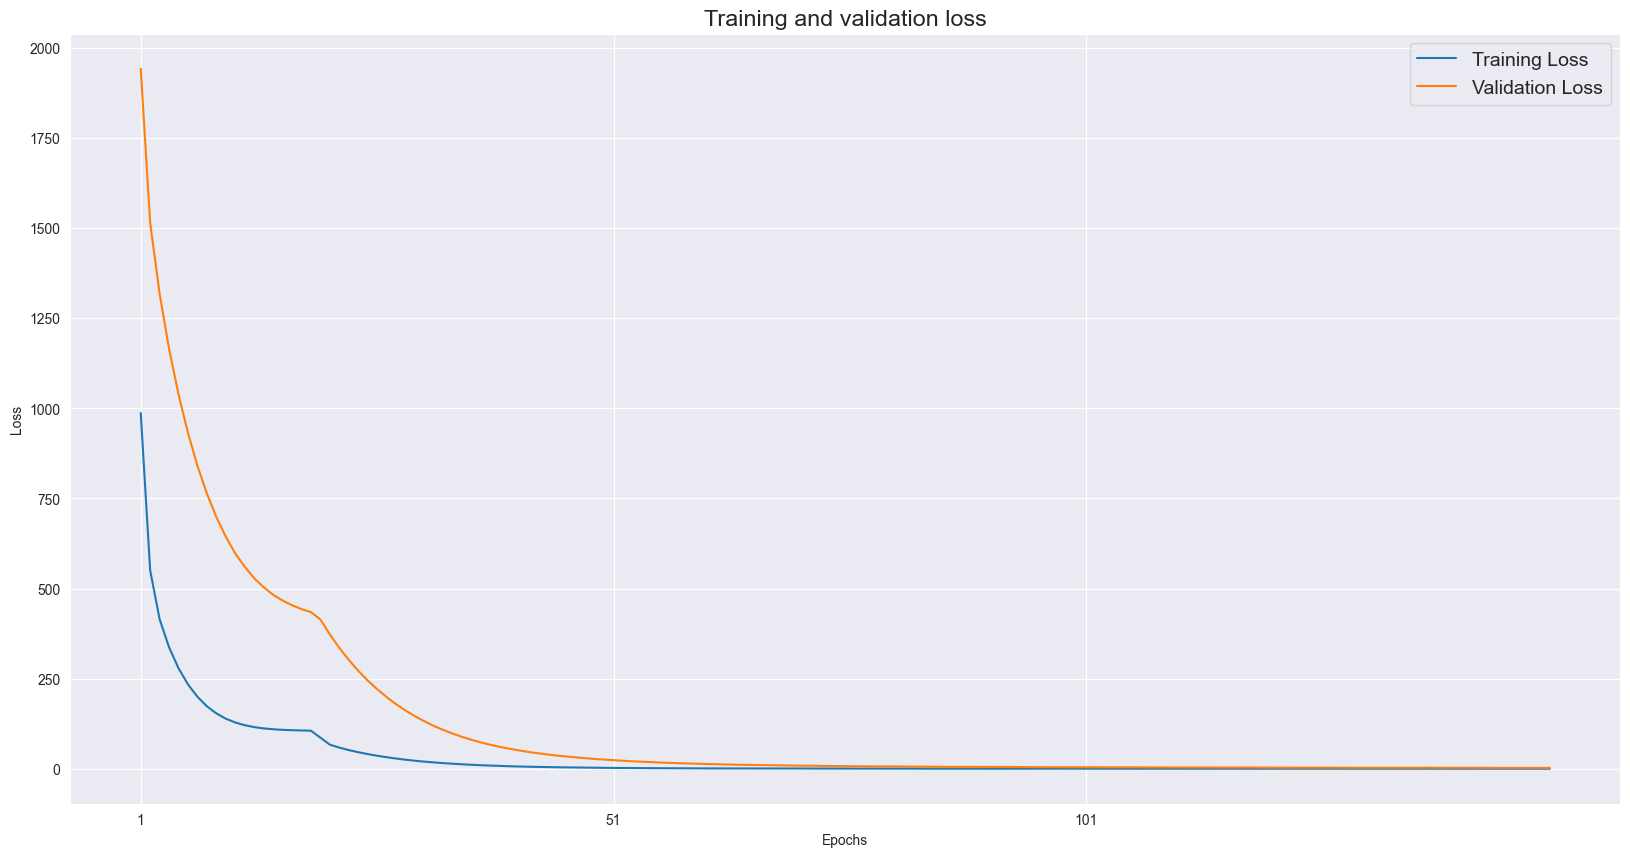

In [34]:
#Showing training and validation loss
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
loss_values50 = loss_values[0:150]
val_loss_values50 = val_loss_values[0:150]
epochs = range(1, len(loss_values50) + 1)
plt.plot(epochs, loss_values50, label='Training Loss')
plt.plot(epochs, val_loss_values50, label='Validation Loss')
plt.rc('font', size = 14)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)
plt.xticks(np.arange(min(epochs), max(epochs)+1, 50.0))
#fig.savefig('test&validationlosscnn.png', dpi=300)
plt.show()

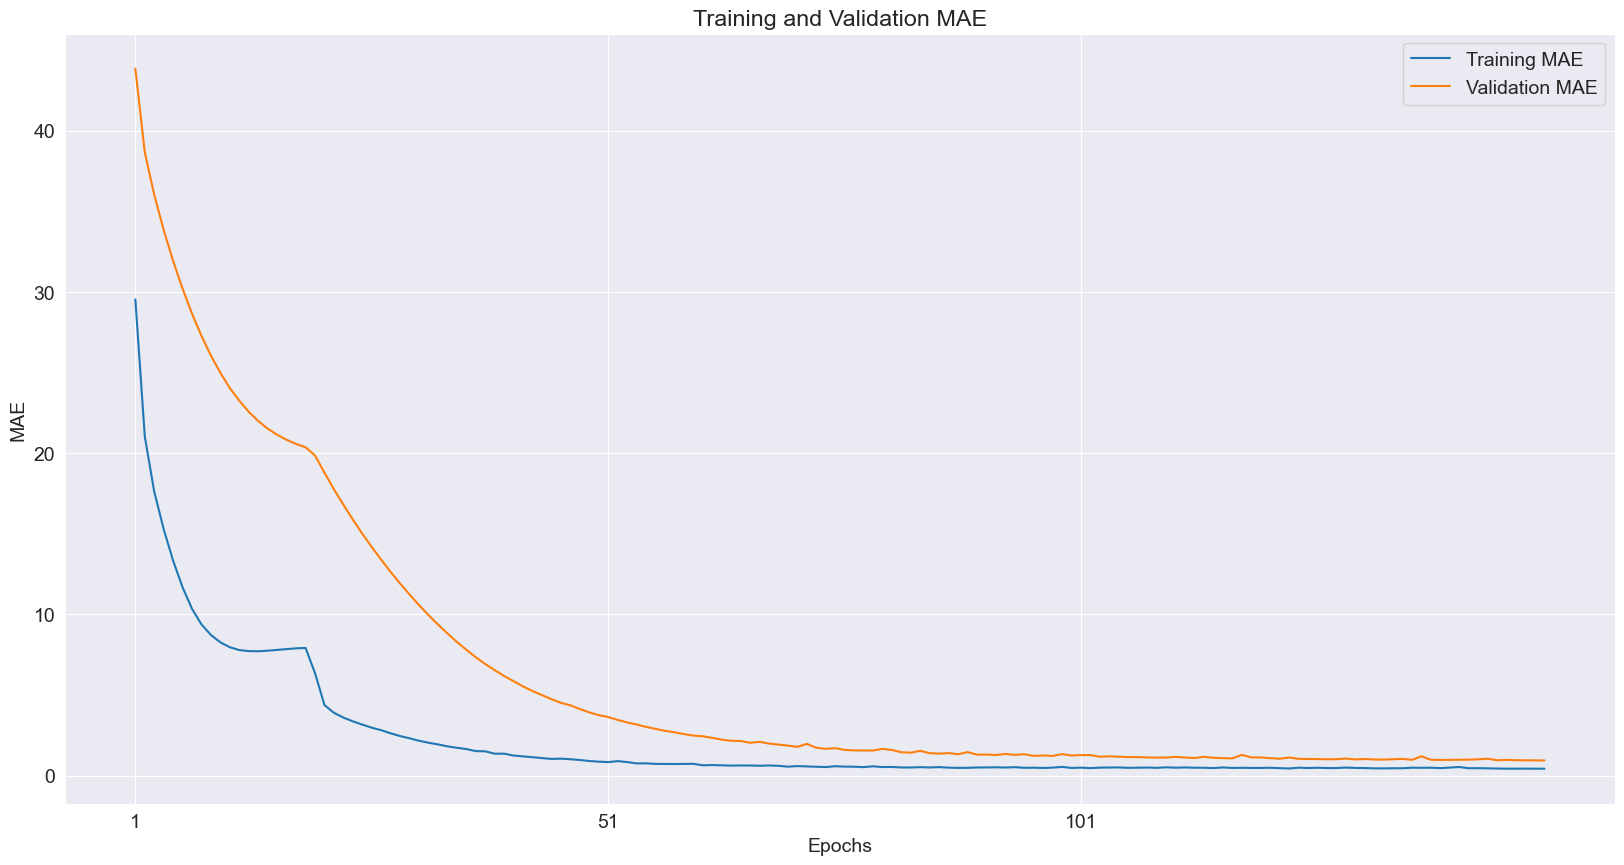

In [35]:
loss_values = history_dict['mae']
val_loss_values = history_dict['val_mae']
loss_values50 = loss_values[0:150]
val_loss_values50 = val_loss_values[0:150]
epochs = range(1, len(loss_values50) + 1)
plt.plot(epochs, loss_values50, label='Training MAE')
plt.plot(epochs, val_loss_values50, label='Validation MAE')
plt.rc('font', size = 14)
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.xticks(epochs)
plt.xticks(np.arange(min(epochs), max(epochs)+1, 50.0))
#fig.savefig('test&validationlosscnn.png', dpi=300)
plt.show()

In [36]:
#Evaluating model
trainScore = model.evaluate(Xtrain, Ytrain, verbose=1)
validScore = model.evaluate(Xvalid, Yvalid, verbose=1)
testScore = model.evaluate(Xtest, Ytest, verbose=1)

24/24 [==============================] - 0s 8ms/step - loss: 1.1175 - mae: 0.7695


In [37]:
testScore, validScore, trainScore

([1.1175425052642822, 0.769524097442627],
 [2.300994396209717, 0.8614681363105774],
 [0.4268752634525299, 0.4200892150402069])

In [38]:
preds = model.predict(Xtest)

24/24 [==============================] - 4s 8ms/step


In [39]:
Xtest.shape

(745, 4, 1)

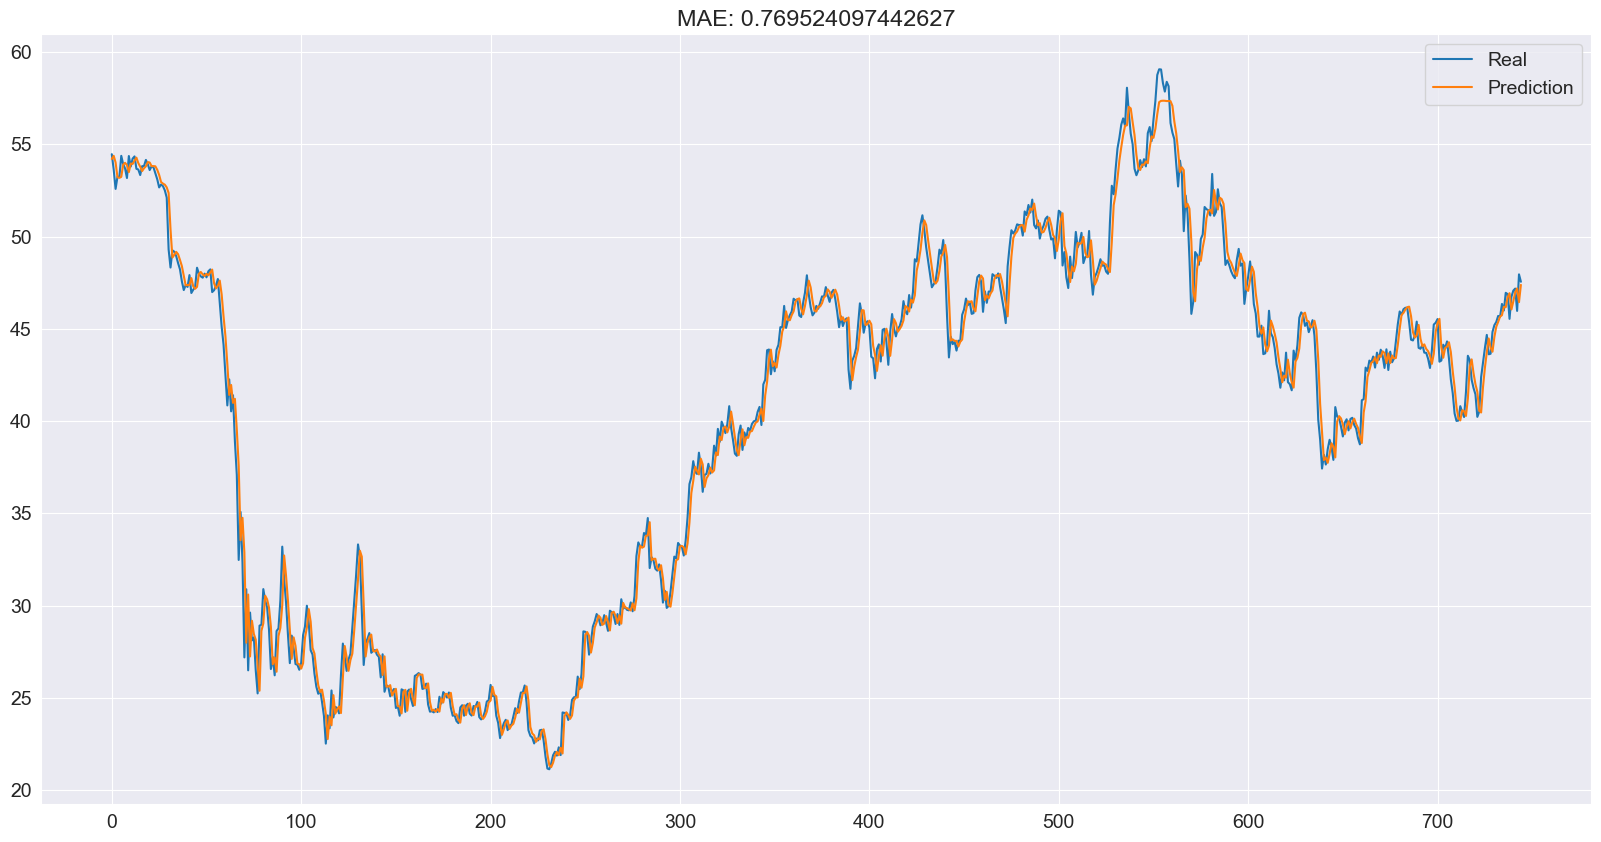

In [40]:
plt.title('MAE: {}'.format(testScore[1]))
plt.plot(Ytest, label='Real')
plt.plot(preds, label='Prediction')

plt.legend(loc="best")

#for saving figures
# plt.savefig('CPALL_graph.png')
plt.show()

In [41]:
#denormalizing datasets
# preds = scaler.inverse_transform(preds)
# Ytest = scaler.inverse_transform(Ytest)

In [42]:
#Show Train and Test Scores
print('Train MSE \t Train RMSE \t Train MAE \t Testscore RMSE \tTest MSE \tTest MAE')
print('%.9f \t %.9f \t %.9f \t %.9f \t \t %.9f \t %.9f' % (trainScore[0], math.sqrt(trainScore[0]),trainScore[1],math.sqrt(testScore[0]),testScore[0],testScore[1]))

Train MSE 	 Train RMSE 	 Train MAE 	 Testscore RMSE 	Test MSE 	Test MAE
0.426875263 	 0.653356919 	 0.420089215 	 1.057138830 	 	 1.117542505 	 0.769524097


In [43]:
print('MAE \t\t MAPE')
print('%.4f \t\t %.4f' % (mean_absolute_error(Ytest,preds),(np.mean(np.abs((Ytest - preds) / Ytest)) * 100)))

MAE 		 MAPE
0.7695 		 2.0269
